# Test Functions for Kriging

In [ ]:
from spotpython.build.kriging import Kriging
import numpy as np
import matplotlib.pyplot as plt
from numpy import linspace, arange
rng = np.random.RandomState(1)
X = linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))
training_indices = rng.choice(arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]
S = Kriging(name='kriging', seed=124)
S.fit(X_train, y_train)
mean_prediction, std_prediction, s_ei = S.predict(X, return_val="all")
plt.plot(X, y, label=r"$f(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
    )
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")
plt.show()

In [ ]:
from spotpython.build.kriging import Kriging
import numpy as np
import matplotlib.pyplot as plt
from numpy import linspace, arange
rng = np.random.RandomState(1)
X = linspace(start=0, stop=10, num=1_0).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))
training_indices = rng.choice(arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]
S = Kriging(name='kriging', seed=124)
S.fit(X_train, y_train)
mean_prediction, std_prediction, s_ei = S.predict(X, return_val="all")
# Kriging is a interpolator, so the mean prediction should be equal to the training points:
# check if the difference between the mean prediction and the true value in the training points is smaller than 1e-6
assert np.allclose(mean_prediction[training_indices], y[training_indices], atol=1e-6)


## Kriging predict

In [ ]:
from spotpython.build.kriging import Kriging
import numpy as np
import matplotlib.pyplot as plt
from numpy import linspace, arange
rng = np.random.RandomState(1)
X = linspace(start=0, stop=10, num=1_0).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))
training_indices = rng.choice(arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]
S = Kriging(name='kriging', seed=124)
S.fit(X_train, y_train)
mean_prediction, std_prediction, s_ei = S.predict(X, return_val="all")
print(f"mean_prediction: {mean_prediction}")
print(f"std_prediction: {std_prediction}")
print(f"s_ei: {s_ei}")

## Expected Improvement

In [ ]:
from spotpython.build.kriging import Kriging
from math import erf
import numpy as np
S = Kriging(name='kriging', seed=124)
S.aggregated_mean_y = [0.0, 0.0, 0.0, 0.0, 0.0]
# asset that the S.exp_imp(1.0, 0.0) is equal to 0.0
assert 0.0 == S.exp_imp(1.0, 0.0)
# assert that the S.exp_imp(0.0, 1.0) is equal to 1/sqrt(2 pi)
# assert S.exp_imp(0.0, 1.0) == 1/np.sqrt(2*np.pi)
# play safe and use np.allclose
assert np.allclose(S.exp_imp(0.0, 1.0), 1/np.sqrt(2*np.pi), atol=1e-6)
assert np.allclose(S.exp_imp(1.0, 1.0), -(0.5 + 0.5*erf(-1/np.sqrt(2))) + 1/np.sqrt(2*np.pi)*np.exp(-1/2), atol=1e-6)

# set_de_bounds

In [ ]:
from spotpython.build.kriging import Kriging
S = Kriging(name='kriging', seed=124)
S.set_de_bounds()
assert S.de_bounds == [[-3, 2]]
from spotpython.build.kriging import Kriging
n = 10
S = Kriging(name='kriging', seed=124, n_theta=n)
S.set_de_bounds()
assert len(S.de_bounds) == n
n=2
p=4
S = Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True)
S.set_de_bounds()
assert len(S.de_bounds) == n+p
S = Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=False)
S.set_de_bounds()
assert len(S.de_bounds) == n

## extract_from_bounds

In [ ]:
import numpy as np
from spotpython.build.kriging import Kriging
n=2
p=2
S = Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=False)
S.extract_from_bounds(np.array([1, 2, 3]))
assert len(S.theta) == n

## optimize_model

In [ ]:
from spotpython.build.kriging import Kriging
import numpy as np
nat_X = np.array([[1, 2], [3, 4]])
nat_y = np.array([1, 2])
n=2
p=2
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=True)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
S.set_theta_values()
S.initialize_matrices()
S.set_de_bounds()
new_theta_p_Lambda = S.optimize_model()
assert len(new_theta_p_Lambda) == n+p+1
# no noise, so Lambda is not considered
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=False)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
S.set_theta_values()
S.initialize_matrices()
S.set_de_bounds()
new_theta_p_Lambda = S.optimize_model()
assert len(new_theta_p_Lambda) == n+p

## update_log

In [ ]:
from spotpython.build.kriging import Kriging
import numpy as np
nat_X = np.array([[1, 2], [3, 4]])
nat_y = np.array([1, 2])
n=2
p=2
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=True)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
S.set_theta_values()
S.initialize_matrices()
S.set_de_bounds()
new_theta_p_Lambda = S.optimize_model()
S.update_log()
print(S.log)
assert len(S.log["negLnLike"]) == 1
assert len(S.log["theta"]) == n
assert len(S.log["p"]) == p
assert len(S.log["Lambda"]) == 1
S.update_log()
print(S.log)
assert len(S.log["negLnLike"]) == 2
assert len(S.log["theta"]) == 2*n
assert len(S.log["p"]) == 2*p
assert len(S.log["Lambda"]) == 2

## fit

In [ ]:
from spotpython.build.kriging import Kriging
import numpy as np
nat_X = np.array([[.1, 0], [0, .1]])
nat_y = np.array([1, 2])
S = Kriging()
S.fit(nat_X, nat_y)
assert S.Psi.shape == (2, 2)
assert len(S.log["negLnLike"]) == 1
print(S.Psi)

## initialize_variables

In [ ]:
from spotpython.build.kriging import Kriging
import numpy as np
nat_X = np.array([[1, 2], [3, 4]])
nat_y = np.array([1, 2])
S = Kriging()
S.initialize_variables(nat_X, nat_y)
assert S.nat_X.all() == nat_X.all()
assert S.nat_y.all() == nat_y.all()
assert S.nat_X.shape == (2, 2)
assert S.nat_y.shape == (2,)
print(f"S.nat_X: {S.nat_X}")
print(f"S.nat_y: {S.nat_y}")


## set_variable_types

In [ ]:
from spotpython.build.kriging import Kriging
import numpy as np
nat_X = np.array([[1, 2], [3, 4]])
nat_y = np.array([1, 2])
n=2
p=2
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=True)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
assert S.var_type == ['num', 'num']
assert S.num_mask.all() == True
assert S.factor_mask.all() == False
assert S.int_mask.all() == False
assert S.ordered_mask.all() == True
S.num_mask

In [ ]:


nat_X = np.array([[1, 2, 3], [4, 5, 6]])
nat_y = np.array([1, 2])
n=3
p=1
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=True)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
S.var_type
assert S.var_type == ['num', 'num', 'num']

## set_theta_values

In [ ]:
from spotpython.build.kriging import Kriging
import numpy as np
from numpy import array
nat_X = np.array([[1, 2], [3, 4]])
nat_y = np.array([1, 2])
n=2
p=2
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=True)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
S.set_theta_values()
assert S.theta.all() == array([0., 0.]).all()
nat_X = np.array([[1, 2], [3, 4]])
nat_y = np.array([1, 2])
# n is set to 3, but the number of columns of nat_X is 2
n=3
p=2
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=True)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
snt = S.n_theta
S.set_theta_values()
# since snt == 3, it is not equal to S.n_theta, which is 2 because 
# of the correction in the set_theta_values method
assert S.n_theta != snt


## initialize_matrices

In [ ]:
from spotpython.build.kriging import Kriging
import numpy as np
from numpy import log, var
nat_X = np.array([[1, 2], [3, 4], [5, 6]])
nat_y = np.array([1, 2, 3])
n=3
p=1
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=True)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
S.set_theta_values()
S.initialize_matrices()
# if var(self.nat_y) is > 0, then self.pen_val = self.n * log(var(self.nat_y)) + 1e4
# else self.pen_val = self.n * var(self.nat_y) + 1e4
assert S.pen_val == nat_X.shape[0] * log(var(S.nat_y)) + 1e4
assert S.Psi.shape == (n, n)
#
# use a zero variance, then the penalty should be computed without log()
nat_y = np.array([1, 1, 1])
n=3
p=1
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=True)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
S.set_theta_values()
S.initialize_matrices()
# if var(self.nat_y) is > 0, then self.pen_val = self.n * log(var(self.nat_y)) + 1e4
# else self.pen_val = self.n * var(self.nat_y) + 1e4
assert S.pen_val == nat_X.shape[0] * (var(S.nat_y)) + 1e4
assert S.Psi.shape == (n, n)


## test is_any()

In [ ]:
from spotpython.build.kriging import Kriging
from numpy import power
import numpy as np
nat_X = np.array([[0], [1]])
nat_y = np.array([0, 1])
n=1
p=1
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=False)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
S.set_theta_values()
assert np.equal(S.__is_any__(power(10.0, S.theta), 0), False)
assert np.equal(S.__is_any__(S.theta, 0), True)

## fun_likelihood

In [ ]:
from spotpython.build.kriging import Kriging
import numpy as np
nat_X = np.array([[0], [1]])
nat_y = np.array([0, 1])
n=1
p=1
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=False)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
print(S.nat_X)
print(S.nat_y)
S.set_theta_values()
print(f"S.theta: {S.theta}")
S.initialize_matrices()
S.set_de_bounds()
new_theta_p_Lambda = S.optimize_model()
S.extract_from_bounds(new_theta_p_Lambda)
print(f"S.theta: {S.theta}")
S.build_Psi()
print(f"S.Psi: {S.Psi}")
S.build_U()
print(f"S.U:{S.U}")
S.likelihood()
# assert S.negLnLike < 0
S.negLnLike

In [ ]:
from spotpython.build.kriging import Kriging
import numpy as np
nat_X = np.array([[0,1], [1, 0]])
nat_y = np.array([0, 10])
n=2
p=1
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=False)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
print(S.nat_X)
print(S.nat_y)
S.set_theta_values()
print(f"S.theta: {S.theta}")
S.initialize_matrices()
print(f"S.mu: {S.mu}")
S.set_de_bounds()
new_theta_p_Lambda = S.optimize_model()
print(f"S.mu: {S.mu}")
S.extract_from_bounds(new_theta_p_Lambda)
print(f"S.theta: {S.theta}")
S.build_Psi()
print(f"S.Psi: {S.Psi}")
S.build_U()
print(f"S.U:{S.U}")
print(f"S.mu: {S.mu}")
S.likelihood()
print(f"S.mu: {S.mu}")
# assert S.negLnLike < 0
S.negLnLike

## Kriging Example 1D

In [ ]:
from spotpython.build.kriging import Kriging
import numpy as np
nat_X = np.array([[1], [2]])
nat_y = np.array([5, 10])
n=2
p=1
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=False, theta_init_zero=True)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
S.set_theta_values()
S.initialize_matrices()
S.build_Psi()
S.build_U()
S.likelihood()
# assert S.mu is close to 7.5 with a tolerance of 1e-6
assert np.allclose(S.mu, 7.5, atol=1e-6)
E = np.exp(1)
sigma2 = E/(E**2 -1) * (25/4 + 25/4*E)
# asssert S.SigmaSqr is close to sigma2 with a tolerance of 1e-6
assert np.allclose(S.SigmaSqr, sigma2, atol=1e-6)


## Test spot initialize_design()

In [ ]:
import numpy as np
from math import inf
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 3
# additional start point
X_start = np.array([[10, 10]])
# number of points
n = 10

fun = analytical().fun_sphere
lower = np.array([1, 1])
upper = np.array([10, 100])
design_control={"init_size": ni}

spot_1 = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
            fun_evals = n,
            show_progress=True,
            design_control=design_control,)
spot_1.initialize_design(X_start=X_start)
spot_1.X

## test build_psi_vec()

In [ ]:
import numpy as np
from spotpython.build.kriging import Kriging
X_train = np.array([[1., 2.],
                    [2., 4.],
                    [3., 6.]])
y_train = np.array([1., 2., 3.])
S = Kriging(name='kriging',
            seed=123,
            log_level=50,
            n_theta=1,
            noise=False,
            cod_type="norm")
S.fit(X_train, y_train)
# force theta to simple values:
S.theta = np.array([0.0])
nat_X = np.array([1., 0.])
S.psi = np.zeros((S.n, 1))
S.build_psi_vec(nat_X)
res = np.array([[np.exp(-4)],
    [np.exp(-17)],
    [np.exp(-40)]])
assert np.array_equal(S.psi, res)
print(f"S.psi:\n {S.psi}")
print(f"Control value res:\n {res}")

## spot: test update_ranges():

In [ ]:
import numpy as np
from math import inf
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 2
# additional start point
X_start = np.array([[10, 10]])
# number of points
n = 10

fun = analytical().fun_sphere
lower = np.array([1, 1])
upper = np.array([10, 100])
design_control={"init_size": ni}

spot_1 = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
            fun_evals = n,
            show_progress=True,
            var_type=['int', 'int'],
            design_control=design_control,)
spot_1.initialize_design(X_start=X_start)
spot_1. update_stats()
print(f"spot_1.X: {spot_1.X}")
print(f"spot_1.lower: {spot_1.lower}")
print(f"spot_1.upper: {spot_1.upper}")
# spot_1.X has entries like:
# [
#  [10, 10]
#  [ 7, 97]
#  [ 5, 41]
# ]
# spot_1.range_X has entries like:
# [
#  [ 5, 10] # min values for all dimensions (lower)
#  [10, 97] # max values for all dimensions (upper)
# ]
# check if the first entries in spot_1.X values are in the interval spot_1.range_X[0]
assert np.all(spot_1.X[:, 0] >= spot_1.lower[0])
assert np.all(spot_1.X[:, 0] <= spot_1.upper[0])
# check if the second entries in spot_1.X values are in the interval spot_1.range_X[1]
assert np.all(spot_1.X[:, 1] >= spot_1.lower[1])
assert np.all(spot_1.X[:, 1] <= spot_1.upper[1])

# test spot plot()

In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 5
# additional start point
X_start = np.array([10])
# number of points
n = 7

fun = analytical().fun_sphere
lower = np.array([-1])
upper = np.array([10])
design_control={"init_size": ni}

spot_1 = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
            cod_type="norm",
            fun_evals = n,
            show_progress=True,
            var_type=['num'],
            design_control=design_control,)
spot_1.run()
np.min([np.min(spot_1.y), np.min(spot_1.y)])
#spot_1.plot_model(y_min=0, y_max=100)
#spot_1.get_spot_attributes_as_df()
print(f"spot_1.X: {spot_1.X}")
print(f"spot_1.y: {spot_1.y}")




## spot test_evaluate_new_x

In [ ]:
import numpy as np
from spotpython.spot import spot
from spotpython.fun.objectivefunctions import analytical
nn = 3
fun_sphere = analytical().fun_sphere
spot_1 = spot.Spot(
    fun=fun_sphere,
    lower=np.array([-1, -1]),
    upper=np.array([1, 1]),
    n_points=nn,
)
# (S-2) Initial Design:
spot_1.X = spot_1.design.scipy_lhd(
    spot_1.design_control["init_size"], lower=spot_1.lower, upper=spot_1.upper
)
print(f"spot_1.X: {spot_1.X}")
# (S-3): Eval initial design:
spot_1.y = spot_1.fun(spot_1.X)
print(f"spot_1.y: {spot_1.y}")
spot_1.fit_surrogate()
X0 = spot_1.suggest_new_X()
print(f"X0: {X0}")
assert X0.size == spot_1.n_points * spot_1.k
assert X0.ndim == 2
assert X0.shape[0] == nn
assert X0.shape[1] == 2

# spot run()

In [ ]:
import numpy as np
from math import inf
from spotpython.spot import spot
def objective_function(X, fun_control=None):
    if not isinstance(X, np.ndarray):
        X = np.array(X)
    if X.shape[1] != 2:
        raise Exception
    x0 = X[:, 0]
    x1 = X[:, 1]
    y = x0**2 + 10*x1**2
    return y
lower = np.array([0, 0])
upper = np.array([10, 10])
spot = spot.Spot(fun=objective_function,
            lower=lower,
            upper=upper,
            fun_evals=8,
            fun_repeats=1,
            max_time=inf,
            noise=False,
            tolerance_x=0,
            ocba_delta=0,
            var_type=["num", "num"],
            infill_criterion="ei",
            n_points=1,
            seed=123,
            log_level=20,
            show_models=False,
            show_progress=True,
            design_control={"init_size": 5, "repeats": 1},
            surrogate_control={"model_fun_evals": 1000,
                               "min_theta": -3.,
                               "max_theta": 3.,
                               "n_theta": 2,
                               "theta_init_zero": True,
                               "n_p": 1,
                               "optim_p": False,
                               "var_type": ["num", "num"],
                               "seed": 124,},
            optimizer_control={"max_iter": 1000})
spot.run()
spot.plot_progress()
spot.plot_contour(i=0, j=1)
spot.plot_importance()

## test initialize_design()

In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 7


fun = analytical().fun_sphere
lower = np.array([-1])
upper = np.array([1])
design_control={"init_size": ni}

S = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
            show_progress=True,
            design_control=design_control,)
S.initialize_design()
S.X.shape
assert S.X.shape[0] == ni
assert S.X.shape[1] == lower.size



In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 7
# start point X_0
X_start = np.array([0, 0.5])


fun = analytical().fun_sphere
lower = np.array([-1, -1])
upper = np.array([1, 2])
design_control={"init_size": ni}

S = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
            show_progress=True,
            design_control=design_control,)
S.initialize_design()
print(f"S.X: {S.X}")
assert S.X.shape[0] == ni
assert S.X.shape[1] == lower.size



In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 7
# start point X_0
X_start = np.array([0, 0]).reshape(1, -1)


fun = analytical().fun_sphere
lower = np.array([-1, -1])
upper = np.array([1, 1])
design_control={"init_size": ni}

S = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
            show_progress=True,
            design_control=design_control,)
S.initialize_design(X_start=X_start)
print(f"S.X: {S.X}")
assert S.X.shape[0] == ni + np.atleast_2d(X_start).shape[0]
assert S.X.shape[1] == lower.size



In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 7
# start point X_0
X_start = np.array([0, 0])


fun = analytical().fun_sphere
lower = np.array([-1, -1])
upper = np.array([1, 1])
design_control={"init_size": ni}

S = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
            show_progress=True,
            design_control=design_control,)
S.initialize_design(X_start=X_start)
print(f"S.X: {S.X}")
assert S.X.shape[0] == ni + np.atleast_2d(X_start).shape[0]
assert S.X.shape[1] == lower.size



In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 7
# start point X_0
X_start = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])


fun = analytical().fun_sphere
lower = np.array([-1, -1])
upper = np.array([1, 1])
design_control={"init_size": ni}

S = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
            show_progress=True,
            design_control=design_control,)
S.initialize_design(X_start=X_start)
print(f"S.X: {S.X}")
print(f"S.y: {S.y}")
assert S.X.shape[0] == ni + np.atleast_2d(X_start).shape[0]
assert S.X.shape[1] == lower.size

## test update_stats()

In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 0
X_start = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])


fun = analytical().fun_sphere
lower = np.array([-1, -1])
upper = np.array([1, 1])
design_control={"init_size": ni}

S = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
            show_progress=True,
            design_control=design_control,)
S.initialize_design(X_start=X_start)
print(f"S.X: {S.X}")
print(f"S.y: {S.y}")
S.update_stats()
assert np.equal(S.min_X, X_start[0]).all()
assert S.min_y == fun(X_start[0])
assert S.counter == X_start.shape[0]
# Since noise is False, the following statics should be None:
assert S.mean_X is None
assert S.mean_y is None
assert S.var_y is None
assert S.min_mean_X is None
assert S.min_mean_y is None



In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 0
X_start = np.array([[0, 0], [0, 1], [1, 0], [1, 1], [1, 1]])

fun = analytical().fun_sphere
lower = np.array([-1, -1])
upper = np.array([1, 1])
design_control={"init_size": ni}

S = spot.Spot(fun=fun,
              noise=True,
            lower = lower,
            upper= upper,
            show_progress=True,
            design_control=design_control,)
S.initialize_design(X_start=X_start)
print(f"S.X: {S.X}")
print(f"S.y: {S.y}")
S.update_stats()
assert np.equal(S.min_X, X_start[0]).all()
assert S.min_y == fun(X_start[0])
assert S.counter == X_start.shape[0]
# the X values are aggregated, the last two rows are equal,
# so the mean_X should have only 4 rows
assert np.equal(S.mean_X,
                np.array([[0., 0.],
                          [0., 1.],
                          [1., 0.],
                          [1., 1.]])).all()
# the y values are also aggregated, there are only 4 values
assert np.equal(S.mean_y, np.array([0., 1., 1., 2.])).all()


In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 0
X_start = np.array([[0, 0], [0, 1], [1, 0], [1, 1], [1, 1]])

fun = analytical().fun_sphere
lower = np.array([-1, -1])
upper = np.array([1, 1])
design_control={"init_size": ni}

S = spot.Spot(fun=fun,
              noise=False,
            lower = lower,
            upper= upper,
            show_progress=True,
            design_control=design_control,)
S.initialize_design(X_start=X_start)
print(f"S.X: {S.X}")
print(f"S.y: {S.y}")
S.update_stats()
assert np.equal(S.min_X, X_start[0]).all()
assert S.min_y == fun(X_start[0])
assert S.counter == X_start.shape[0]
# Since noise is False, the following statics should be None:
assert S.mean_X is None
assert S.mean_y is None
assert S.var_y is None
assert S.min_mean_X is None
assert S.min_mean_y is None
# the X values are not aggregated, the last two equal rows ae not modified:
assert np.equal(S.X,
                np.array([[0., 0.],
                          [0., 1.],
                          [1., 0.],
                          [1., 1.],
                          [1., 1.]])).all()

## test fit_surrogate()

In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 0
X_start = np.array([[0, 0], [0, 1], [1, 0], [1, 1], [1, 1]])

fun = analytical().fun_sphere
lower = np.array([-1, -1])
upper = np.array([1, 1])
design_control={"init_size": ni}

S = spot.Spot(fun=fun,
              noise=False,
            lower = lower,
            upper= upper,
            show_progress=True,
            design_control=design_control,)
S.initialize_design(X_start=X_start)
print(f"S.X: {S.X}")
print(f"S.y: {S.y}")
S.update_stats()
S.fit_surrogate()
assert S.surrogate.Psi.shape[0] == S.X.shape[0]


## test update_design()

In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 0
X_start = np.array([[0, 0], [0, 1], [1, 0], [1, 1], [1, 1]])

fun = analytical().fun_sphere
lower = np.array([-1, -1])
upper = np.array([1, 1])
design_control={"init_size": ni}

S = spot.Spot(fun=fun,
              noise=False,
            lower = lower,
            upper= upper,
            show_progress=True,
            design_control=design_control,)
S.initialize_design(X_start=X_start)
print(f"S.X: {S.X}")
print(f"S.y: {S.y}")
X_shape_before = S.X.shape
print(f"X_shape_before: {X_shape_before}")
print(f"y_size_before: {S.y.size}")
y_size_before = S.y.size
S.update_stats()
S.fit_surrogate()
S.update_design()
print(f"S.X: {S.X}")
print(f"S.y: {S.y}")
print(f"S.n_points: {S.n_points}")
print(f"X_shape_after: {S.X.shape}")
print(f"y_size_after: {S.y.size}")
# compare the shapes of the X and y values before and after the update_design method
assert X_shape_before[0] + S.n_points == S.X.shape[0]
assert X_shape_before[1] == S.X.shape[1]
assert y_size_before + S.n_points == S.y.size

In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
from spotpython.utils.init import fun_control_init
# number of initial points:
ni = 3
X_start = np.array([[0, 1], [1, 0], [1, 1], [1, 1]])

fun = analytical().fun_sphere
fun_control = fun_control_init(
        sigma=0.02,
        seed=123,)
lower = np.array([-1, -1])
upper = np.array([1, 1])
design_control={"init_size": ni,
                "repeats": 2}

S = spot.Spot(fun=fun,
              noise=True,
              fun_repeats=2,
              n_points=1,
              ocba_delta=1,
            lower = lower,
            upper= upper,
            show_progress=True,
            design_control=design_control,
            fun_control=fun_control
)
S.initialize_design(X_start=X_start)
print(f"S.X: {S.X}")
print(f"S.y: {S.y}")
X_shape_before = S.X.shape
print(f"X_shape_before: {X_shape_before}")
print(f"y_size_before: {S.y.size}")
y_size_before = S.y.size
S.update_stats()
S.fit_surrogate()
S.update_design()
print(f"S.X: {S.X}")
print(f"S.y: {S.y}")
print(f"S.n_points: {S.n_points}")
print(f"S.ocba_delta: {S.ocba_delta}")
print(f"X_shape_after: {S.X.shape}")
print(f"y_size_after: {S.y.size}")
# compare the shapes of the X and y values before and after the update_design method
assert X_shape_before[0] + S.n_points * S.fun_repeats + S.ocba_delta == S.X.shape[0]
assert X_shape_before[1] == S.X.shape[1]
assert y_size_before + S.n_points * S.fun_repeats + S.ocba_delta == S.y.size

## test get_new_X0()

In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
from spotpython.utils.init import fun_control_init
# number of initial points:
ni = 3
X_start = np.array([[0, 1], [1, 0], [1, 1], [1, 1]])

fun = analytical().fun_sphere
fun_control = fun_control_init(
        sigma=0.0,
        seed=123,)
lower = np.array([-1, -1])
upper = np.array([1, 1])
design_control={"init_size": ni,
                "repeats": 1}

S = spot.Spot(fun=fun,
              noise=False,
              fun_repeats=1,
              n_points=10,
              ocba_delta=0,
            lower = lower,
            upper= upper,
            show_progress=True,
            design_control=design_control,
            fun_control=fun_control
)
S.initialize_design(X_start=X_start)
S.update_stats()
S.fit_surrogate()
X_ocba = None
X0 = S.get_new_X0()
assert X0.shape[0] == S.n_points
assert X0.shape[1] == S.lower.size
# assert new points are in the interval [lower, upper]
assert np.all(X0 >= S.lower)
assert np.all(X0 <= S.upper)
# print using 20 digits precision
np.set_printoptions(precision=20)
print(f"X0: {X0}")



## test selectNew()

In [ ]:
from spotpython.utils.compare import selectNew
import numpy as np
A = np.array([[1,2,3],[4,5,6]])
X = np.array([[1,2,3],[4,5,6]])
B, ind  = selectNew(A, X)
assert B.shape[0] == 0
assert np.equal(ind, np.array([False, False])).all()

In [ ]:
A = np.array([[1,2,3],[4,5,7]])
X = np.array([[1,2,3],[4,5,6]])
B, ind  = selectNew(A, X)
assert B.shape[0] == 1
assert np.equal(ind, np.array([False, True])).all()

## test plots

In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 7
# number of points
fun_evals = 10

fun = analytical().fun_sphere
lower = np.array([-1, -1])
upper = np.array([1, 1])
design_control={"init_size": ni}
surrogate_control={"n_theta": 3}
S = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
            log_level = 50,
            fun_evals = fun_evals,
            tolerance_x = np.sqrt(np.spacing(1)),
            show_progress=True,
            design_control=design_control,
            surrogate_control=surrogate_control,)
S.run()
S.plot_progress(log_y=True)


In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 5
# number of points
fun_evals = 10

fun = analytical().fun_sphere
lower = np.array([-1, -1, -1])
upper = np.array([1, 1, 1])
design_control={"init_size": ni}
surrogate_control={"n_theta": 3}
S = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
            log_level = 50,
            fun_evals = fun_evals,
            tolerance_x = np.sqrt(np.spacing(1)),
            show_progress=True,
            design_control=design_control,
            surrogate_control=surrogate_control,)
S.run()
S.plot_important_hyperparameter_contour()

In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 5
# number of points
fun_evals = 10

fun = analytical().fun_sphere
lower = np.array([-1, -1, -1])
upper = np.array([1, 1, 1])
design_control={"init_size": ni}
surrogate_control={"n_theta": 3}
S = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
            log_level = 50,
            fun_evals = fun_evals,
            tolerance_x = np.sqrt(np.spacing(1)),
            show_progress=True,
            design_control=design_control,
            surrogate_control=surrogate_control,)
S.run()
S.plot_contour()
S.plot_contour(i=1, j=2)

In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 3
# number of points
fun_evals = 7

fun = analytical().fun_sphere
lower = np.array([-1])
upper = np.array([1])
design_control={"init_size": ni}
surrogate_control={"n_theta": 1}
S = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
            log_level = 50,
            fun_evals = fun_evals,
            tolerance_x = np.sqrt(np.spacing(1)),
            show_progress=True,
            design_control=design_control,
            surrogate_control=surrogate_control,)
S.run()
S.plot_model()


In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 5
# number of points
fun_evals = 10

fun = analytical().fun_sphere
lower = np.array([-1, -1, -1])
upper = np.array([1, 1, 1])
design_control={"init_size": ni}
surrogate_control={"n_theta": 3}
S = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
            log_level = 50,
            fun_evals = fun_evals,
            tolerance_x = np.sqrt(np.spacing(1)),
            show_progress=True,
            design_control=design_control,
            surrogate_control=surrogate_control,)
S.run()
S.parallel_plot()

In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# 1-dimensional example
fun = analytical().fun_sphere
lower = np.array([-1])
upper = np.array([1])
design_control={"init_size": 10}
S = spot.Spot(fun=fun,
              noise=False,
              lower = lower,
              upper= upper,
              design_control=design_control,)
S.initialize_design()
S.update_stats()
S.fit_surrogate()
S.surrogate.plot()
# 2-dimensional example
fun = analytical().fun_sphere
lower = np.array([-1, -1])
upper = np.array([1, 1])
design_control={"init_size": 10}
S = spot.Spot(fun=fun,
              noise=False,
              lower = lower,
              upper= upper,
              design_control=design_control,)
S.initialize_design()
S.update_stats()
S.fit_surrogate()
S.surrogate.plot()

## test ocba

In [ ]:

import copy
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
from spotpython.budget.ocba import get_ocba

# Test based on the example from the book:
# Chun-Hung Chen and Loo Hay Lee:
#     Stochastic Simulation Optimization: An Optimal Computer Budget Allocation,
#     pp. 49 and pp. 215
#     p. 49:
#     mean_y = np.array([1,2,3,4,5])
#     var_y = np.array([1,1,9,9,4])
#     get_ocba(mean_y, var_y, 50)
#     [11  9 19  9  2]

fun = analytical().fun_linear
fun_control = {"sigma": 0.001,
               "seed": 123}
spot_1_noisy = spot.Spot(fun=fun,
                   lower = np.array([-1]),
                   upper = np.array([1]),
                   fun_evals = 20,
                   fun_repeats = 2,
                   noise = True,
                   ocba_delta=1,
                   seed=123,
                   show_models=False,
                   fun_control = fun_control,
                   design_control={"init_size": 3,
                                   "repeats": 2},
                   surrogate_control={"noise": True})
spot_1_noisy.run()
spot_2 = copy.deepcopy(spot_1_noisy)
spot_2.mean_y = np.array([1,2,3,4,5])
spot_2.var_y = np.array([1,1,9,9,4])
n = 50
o = get_ocba(spot_2.mean_y, spot_2.var_y, n)
assert sum(o) == 50
assert (o == np.array([[11, 9, 19, 9, 2]])).all()
o

In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
from spotpython.utils.init import fun_control_init
# number of initial points:
ni = 3
X_start = np.array([[0, 1], [1, 0], [1, 1], [1, 1]])

fun = analytical().fun_sphere
fun_control = fun_control_init(
        sigma=0.02,
        seed=123,)
lower = np.array([-1, -1])
upper = np.array([1, 1])
design_control={"init_size": ni,
                "repeats": 2}

S = spot.Spot(fun=fun,
              noise=True,
              fun_repeats=2,
              n_points=1,
              ocba_delta=1,
               log_level = 10,
            lower = lower,
            upper= upper,
            show_progress=False,
            design_control=design_control,
            fun_control=fun_control
)
S.initialize_design(X_start=X_start)
print(f"S.X: {S.X}")
print(f"S.y: {S.y}")
X_shape_before = S.X.shape
print(f"X_shape_before: {X_shape_before}")
print(f"y_size_before: {S.y.size}")
y_size_before = S.y.size
S.update_stats()
S.fit_surrogate()
S.update_design()
print(f"S.X: {S.X}")
print(f"S.y: {S.y}")
print(f"S.n_points: {S.n_points}")
print(f"S.ocba_delta: {S.ocba_delta}")
print(f"X_shape_after: {S.X.shape}")
print(f"y_size_after: {S.y.size}")


In [ ]:
from spotpython.budget.ocba import get_ocba_X
from spotpython.utils.aggregate import aggregate_mean_var
import numpy as np
X = np.array([[1,2,3],
              [1,2,3],
              [4,5,6],
              [4,5,6],
              [4,5,6],
              [7,8,9],
              [7,8,9],])
y = np.array([1,2,30,40, 40, 500, 600  ])
Z = aggregate_mean_var(X=X, y=y)
mean_X = Z[0]
mean_y = Z[1]
var_y = Z[2]
print(f"X: {X}")
print(f"y: {y}")
print(f"mean_X: {mean_X}")
print(f"mean_y: {mean_y}")
print(f"var_y: {var_y}")
delta = 5
X_new = get_ocba_X(X=mean_X, means=mean_y, vars=var_y, delta=delta,verbose=True)
X_new


In [ ]:
from spotpython.budget.ocba import get_ocba, get_ocba_X
from spotpython.utils.aggregate import aggregate_mean_var
import numpy as np
X = np.array([[1,2,3],
              [1,2,3],
              [4,5,6],
              [4,5,6],
              [4,5,6],
              [4, 5, 6],
              [4, 5 ,6],])
y = np.array([1,2,30,40, 40, 500, 600  ])
Z = aggregate_mean_var(X=X, y=y)
mean_X = Z[0]
mean_y = Z[1]
var_y = Z[2]
print(f"X: {X}")
print((f"mean_X.shape: {mean_X.shape}"))
print(f"y: {y}")
print(f"mean_X: {mean_X}")
print(f"mean_y: {mean_y}")
print(f"var_y: {var_y}")
delta = 5
# get_ocba(means, vars, delta,verbose=True)
X_new = get_ocba_X(X=mean_X, means=mean_y, vars=var_y, delta=delta,verbose=True)
assert X_new is None


In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
fun = analytical().fun_sphere
lower = np.array([-1, -1])
upper = np.array([1, 1])
S = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
)
z0 = [1, 2, 3]
print(f"Before: {z0}")
new_val_1 = 4
new_val_2 = 5
index_1 = 0
index_2 = 2
S.chg(x=new_val_1, y=new_val_2, z0=z0, i=index_1, j=index_2)
print(f"After: {z0}")

## test data set and loader

In [ ]:
import pytest
import torch
from torch.utils.data import DataLoader
from spotpython.data.pkldataset import PKLDataset

# Create an instance of PKLDataset for testing
dataset = PKLDataset(target_column='prognosis')

# Test the length of the dataset
assert len(dataset) > 0

# Test __getitem__
idx = 0
sample = dataset[idx]
assert isinstance(sample, tuple)
assert len(sample) == 2
feature, target = sample
assert isinstance(feature, torch.Tensor)
assert isinstance(target, torch.Tensor)

# Test DataLoader
batch_size = 3
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for batch in dataloader:
    inputs, targets = batch
    assert inputs.size(0) == batch_size
    assert targets.size(0) == batch_size
    break
len(dataset)

In [ ]:
from spotpython.data.pkldataset import PKLDataset
import torch
from torch.utils.data import DataLoader
dataset = PKLDataset(target_column='prognosis', feature_type=torch.long)
# Set batch size for DataLoader
batch_size = 5
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
# Iterate over the data in the DataLoader
for batch in dataloader:
    inputs, targets = batch
    print(f"Batch Size: {inputs.size(0)}")
    print("---------------")
    print(f"Inputs: {inputs}")
    print(f"Targets: {targets}")
    break

In [ ]:
from spotpython.data.pkldataset import PKLDataset
import torch
from torch.utils.data import DataLoader
dataset = PKLDataset(target_column='prognosis', feature_type=torch.long)
print(dataset.data.shape)
print(dataset.targets.shape)


In [ ]:
from spotpython.data.pkldataset import PKLDataset
import torch
from torch.utils.data import DataLoader
dataset = PKLDataset(target_column='prognosis', feature_type=torch.long)
print(len(dataset))     

In [ ]:
from spotpython.data.pkldataset import PKLDataset
import torch
from torch.utils.data import DataLoader
dataset = PKLDataset(target_column='prognosis', feature_type=torch.long)
print(dataset)

In [ ]:
from spotpython.data.pkldataset import PKLDataset
import torch
from torch.utils.data import DataLoader
dataset = PKLDataset(directory="/Users/bartz/workspace/spotpython/notebooks/data/spotpython/",
                filename="data_sensitive.pkl",
                target_column='N',
                feature_type=torch.float32,
                target_type=torch.float32,
                rmNA=False)
len(dataset)

In [ ]:
from spotpython.utils.init import fun_control_init
from spotpython.hyperparameters.values import set_control_key_value
from spotpython.data.lightdatamodule import LightDataModule
from spotpython.data.csvdataset import CSVDataset
from spotpython.data.pkldataset import PKLDataset
import torch
fun_control = fun_control_init()
dataset = CSVDataset(csv_file='data.csv', target_column='prognosis', feature_type=torch.long)
dm = LightDataModule(dataset=dataset, batch_size=5, test_size=7)
dm.setup()
set_control_key_value(control_dict=fun_control,
                key="data_module",
                value=dm, replace=True)
assert isinstance(fun_control["data_module"], LightDataModule)

x1:  98.77069655848275
x2:  100.0


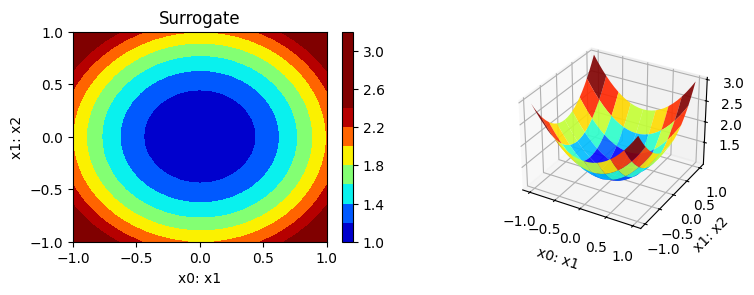

In [3]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
# number of initial points:
ni = 10
# number of points
fun_evals = 10
fun = analytical().fun_sphere
lower = np.array([-1, -1, -1])
upper = np.array([-1, 1, 1])
design_control={"init_size": ni}
surrogate_control={"n_theta": 2}
spot_1 = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
            fun_evals = fun_evals,
            show_progress=True,
            log_level=50,
            design_control=design_control,
            surrogate_control=surrogate_control,)
spot_1.run()
assert spot_1.lower.size == 2
assert spot_1.upper.size == 2
assert len(spot_1.var_type) == 2
assert spot_1.red_dim == True
spot_1.plot_important_hyperparameter_contour()

# Tests >= 0.9.3

In [1]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot
from spotpython.utils.init import fun_control_init

# number of initial points:
ni = 3
X_start = np.array([[0, 1], [1, 0], [1, 1], [1, 1]])

fun = analytical().fun_sphere
fun_control = fun_control_init(
        sigma=0.0,
        seed=123,)
print(f"fun_control: {fun_control}")
lower = np.array([-1, -1])
upper = np.array([1, 1])
design_control={"init_size": ni,
                "repeats": 1}

S = spot.Spot(fun=fun,
            noise=False,
            fun_repeats=1,
            n_points=10,
            ocba_delta=0,
            lower = lower,
            upper= upper,
            show_progress=True,
            design_control=design_control,
            fun_control=fun_control,
            log_level=10
)
S.initialize_design(X_start=X_start)
S.update_stats()
S.fit_surrogate()
X0 = S.get_new_X0()
assert X0.shape[0] == S.n_points
assert X0.shape[1] == S.lower.size
# assert new points are in the interval [lower, upper]
assert np.all(X0 >= S.lower)
assert np.all(X0 <= S.upper)

Seed set to 123


fun_control: {'CHECKPOINT_PATH': 'runs/saved_models/', 'DATASET_PATH': 'data/', 'RESULTS_PATH': 'results/', 'TENSORBOARD_PATH': 'runs/', '_L_in': None, '_L_out': None, 'data': None, 'data_dir': './data', 'data_module': None, 'data_set': None, 'device': None, 'enable_progress_bar': False, 'eval': None, 'fun_evals': inf, 'k_folds': 3, 'log_level': 10, 'loss_function': None, 'max_time': 1, 'metric_river': None, 'metric_sklearn': None, 'metric_torch': None, 'metric_params': {}, 'model_dict': {}, 'n_samples': None, 'num_workers': 0, 'optimizer': None, 'path': None, 'prep_model': None, 'save_model': False, 'seed': 123, 'show_batch_interval': 1000000, 'show_progress': False, 'shuffle': None, 'sigma': 0.0, 'target_column': None, 'tolerance_x': 0, 'train': None, 'test': None, 'task': 'classification', 'spot_tensorboard_path': None, 'var_name': None, 'var_type': None, 'weights': 1.0, 'spot_writer': None}


In [ ]:
import numpy as np
from spotpython.fun.objectivefunctions import analytical
from spotpython.spot import spot

# number of initial points:
ni = 0
X_start = np.array([[0, 0], [0, 1], [1, 0], [1, 1], [1, 1]])

fun = analytical().fun_sphere
lower = np.array([-1, -1])
upper = np.array([1, 1])
design_control={"init_size": ni}

S = spot.Spot(fun=fun,
            noise=True,
            lower = lower,
            upper= upper,
            show_progress=True,
            design_control=design_control,
            log_level=10)
S.initialize_design(X_start=X_start)
print(f"S.X: {S.X}")
print(f"S.y: {S.y}")
S.update_stats()
assert np.equal(S.min_X, X_start[0]).all()
assert S.min_y == fun(X_start[0])
assert S.counter == X_start.shape[0]
# the X values are aggregated, the last two rows are equal,
# so the mean_X should have only 4 rows
assert np.equal(S.mean_X,
                np.array([[0., 0.],
                        [0., 1.],
                        [1., 0.],
                        [1., 1.]])).all()
# the y values are also aggregated, there are only 4 values
print(f"S.mean_y: {S.mean_y}")
print(np.array([0., 1., 1., 2.]))
assert np.equal(S.mean_y, np.array([0., 1., 1., 2.])).all()